In [2]:
import glob
import os
import json
import pandas as pd
from tqdm.auto import tqdm

import numpy as np
from CotModel import CotModel
from LincModel import LincModel
from NaiveModel import NaiveModel

/root/miniconda3/envs/linc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
paths = glob.glob(os.path.join("results/folio", '*.json')) + glob.glob(os.path.join("results/proofwriter", '*.json'))
paths

['results/folio/cot - Llama-2-13b-chat-hf (2024-11-29_06-45-56).json',
 'results/folio/cot - Llama-2-7b-chat-hf (2024-11-29_03-23-47).json',
 'results/folio/cot - Llama-3.1-8B-Instruct (2024-11-28_23-55-42).json',
 'results/folio/cot - Llama-3.2-1B-Instruct (2024-11-28_22-34-15).json',
 'results/folio/cot - Llama-3.2-3B-Instruct (2024-11-28_23-11-19).json',
 'results/folio/linc - Llama-2-13b-chat-hf (2024-12-03_03-17-15).json',
 'results/folio/linc - Llama-2-7b-chat-hf (2024-12-02_19-31-08).json',
 'results/folio/linc - Llama-3.1-8B-Instruct (2024-12-02_16-31-56).json',
 'results/folio/linc - Llama-3.2-1B-Instruct (2024-12-02_16-34-24).json',
 'results/folio/linc - Llama-3.2-3B-Instruct (2024-12-02_16-37-29).json',
 'results/folio/naive - Llama-2-13b-chat-hf (2024-11-28_23-06-36).json',
 'results/folio/naive - Llama-2-7b-chat-hf (2024-11-28_22-07-31).json',
 'results/folio/naive - Llama-3.1-8B-Instruct (2024-11-28_21-55-17).json',
 'results/folio/naive - Llama-3.2-1B-Instruct (2024-11-

In [155]:
def parse_cot(row):
    answers = [CotModel.parse(response) for response in row.responses]
    accuracies = [1 if answer == row["label"] else 0 for answer in answers]
    return answers, accuracies

def parse_linc(row):
    answers = [LincModel.parse(response) for response in row.responses]
    accuracies = [1 if answer == row["label"] else 0 for answer in answers]
    return answers, accuracies

def parse_naive(row):
    answers = [NaiveModel.parse(response) for response in row.responses]
    accuracies = [1 if answer == row["label"] else 0 for answer in answers]
    return answers, accuracies

def get_dataset_path(file_name):
    if "folio" in file_name:
        return "data/folio.csv"
    elif "proofwriter" in file_name:
        return "data/proofwriter.csv"
    else:
        raise Exception()

results_df_dict = {}

for path in tqdm(paths):
    with open(path, "r") as file:
        results = json.load(file)
    data_path = get_dataset_path(path)
    results_df = pd.DataFrame(results)
    results_df["label"] = pd.read_csv(data_path)["label"]

    if "cot" in path:
        results_df[["answers", "accuracies"]] = results_df.apply(lambda row: pd.Series(parse_cot(row)), axis=1)
    elif "linc" in path:
        results_df[["answers", "accuracies"]] = results_df.apply(lambda row: pd.Series(parse_linc(row)), axis=1)
    elif "naive" in path:
        results_df[["answers", "accuracies"]] = results_df.apply(lambda row: pd.Series(parse_naive(row)), axis=1)
    results_df_dict[path] = results_df


100%|██████████| 30/30 [21:39<00:00, 43.31s/it]


In [156]:
import pickle

with open("data/results_df_dict_2.pkl", "wb") as file:
    pickle.dump(results_df_dict, file)

In [4]:
import pickle

with open("data/results_df_dict_2.pkl", "rb") as file:
    results_df_dict = pickle.load(file)


In [5]:
import re

def get_model_choice(file_name):
    if "linc" in file_name:
        return "LINC"
    elif "naive" in file_name:
        return "Naive"
    elif "cot" in file_name:
        return "COT"
    else:
        raise Exception()


def get_model_name(file_name):
    pattern = r"Llama\S*"
    model = re.findall(pattern, file_name)[0]
    conversions = {
        "Llama-2-13b-chat-hf": "Llama 2 13B Chat",
        "Llama-2-7b-chat-hf": "Llama 2 7B Chat",
        "Llama-3.1-8B-Instruct": "Llama 3.1 8B Instruct",
        "Llama-3.2-1B-Instruct": "Llama 3.2 1B Instruct",
        "Llama-3.2-3B-Instruct": "Llama 3.2 3B Instruct",
    }

    for key, value in conversions.items():
        if key in model:
            return model.replace(key, value)
    raise Exception()

def get_dataset_name(file_name):
    if "folio" in file_name:
        return "FOLIO"
    elif "proofwriter" in file_name:
        return "ProofWriter"
    else:
        raise Exception()

all_results = []
for path in tqdm(paths):
    results_df = results_df_dict[path]
    accuracies = np.array(results_df["accuracies"].tolist())
    mean_accuracies = np.round(np.mean(accuracies, axis=0), 4)
    results = {
        "Dataset": get_dataset_name(path),
        "Method": get_model_choice(path),
        "Model": get_model_name(path),
        "Accuracy": np.mean(mean_accuracies),
        "STD": np.std(mean_accuracies, ddof=1) / np.sqrt(np.size(mean_accuracies))
        
    }
    all_results.append(results)

100%|██████████| 30/30 [00:00<00:00, 5498.56it/s]


In [6]:
all_results_df = pd.DataFrame(all_results)
all_results_df

,Dataset,Method,Model,Accuracy,STD
0,FOLIO,COT,Llama 2 13B Chat,0.47140,0.005041
1,FOLIO,COT,Llama 2 7B Chat,0.10880,0.005872
2,FOLIO,COT,Llama 3.1 8B Instruct,0.59780,0.003648
3,FOLIO,COT,Llama 3.2 1B Instruct,0.18570,0.007661
4,FOLIO,COT,Llama 3.2 3B Instruct,0.47692,0.009252
5,FOLIO,LINC,Llama 2 13B Chat,0.30880,0.002694
6,FOLIO,LINC,Llama 2 7B Chat,0.21760,0.007501
7,FOLIO,LINC,Llama 3.1 8B Instruct,0.61870,0.007894
8,FOLIO,LINC,Llama 3.2 1B Instruct,0.17800,0.003300
9,FOLIO,LINC,Llama 3.2 3B Instruct,0.33298,0.006627


In [ ]:
all_results_df.to_csv("results/results.csv", index=False)

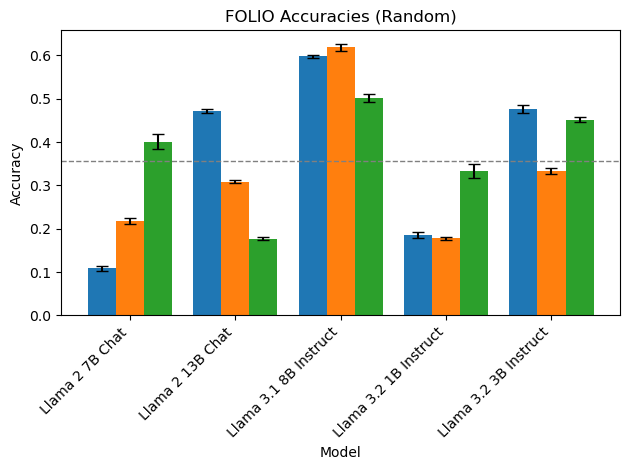

In [21]:
import matplotlib.pyplot as plt

pivot_df = all_results_df[all_results_df["Dataset"] == "FOLIO"].pivot(
    index="Model", columns="Method", values=["Accuracy", "STD"]
)
pivot_df = pivot_df.reindex(
    [
        "Llama 2 7B Chat",
        "Llama 2 13B Chat",
        "Llama 3.1 8B Instruct",
        "Llama 3.2 1B Instruct",
        "Llama 3.2 3B Instruct",
    ]
)

evaluation_df = pd.read_csv("data/folio.csv")
label_counts = evaluation_df["label"].value_counts()
baseline = label_counts.max() / len(evaluation_df)

ax = pivot_df.plot(
    kind="bar",
    y="Accuracy",
    yerr="STD",
    linewidth=1,
    capsize=4,
    width=0.8,
    title="FOLIO Accuracies (Random)",
    legend=False
)
plt.axhline(y=baseline, color="gray", linestyle="--", linewidth=1, label="Baseline")
ax.set_ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

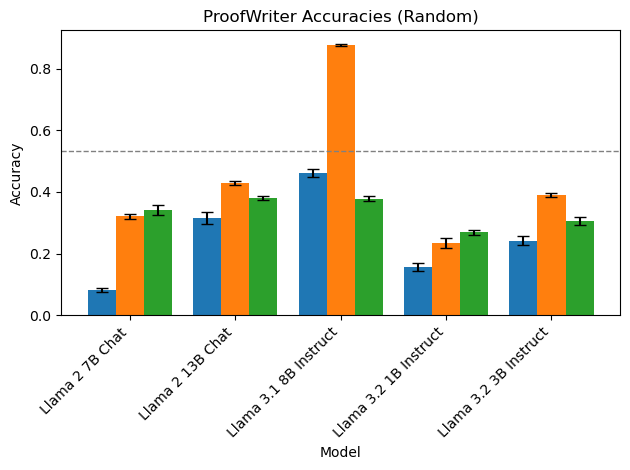

In [20]:
import matplotlib.pyplot as plt

pivot_df = all_results_df[all_results_df["Dataset"] == "ProofWriter"].pivot(
    index="Model", columns="Method", values=["Accuracy", "STD"]
)

pivot_df = pivot_df.reindex(
    [
        "Llama 2 7B Chat",
        "Llama 2 13B Chat",
        "Llama 3.1 8B Instruct",
        "Llama 3.2 1B Instruct",
        "Llama 3.2 3B Instruct",
    ]
)

evaluation_df = pd.read_csv("data/proofwriter.csv")
label_counts = evaluation_df["label"].value_counts()
baseline = label_counts.max() / len(evaluation_df)

ax = pivot_df.plot(
    kind="bar",
    y="Accuracy",
    yerr="STD",
    linewidth=1,
    capsize=4,
    width=0.8,
    title="ProofWriter Accuracies (Random)",
    legend=False
)
plt.axhline(y=baseline, color="gray", linestyle="--", linewidth=1, label="Baseline")
ax.set_ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [10]:
linc_paths = glob.glob(os.path.join("results/folio", 'linc*.json')) + glob.glob(os.path.join("results/proofwriter", 'linc*.json'))

In [11]:
linc_paths

['results/folio/linc - Llama-2-13b-chat-hf (2024-12-03_03-17-15).json',
 'results/folio/linc - Llama-2-7b-chat-hf (2024-12-02_19-31-08).json',
 'results/folio/linc - Llama-3.1-8B-Instruct (2024-12-02_16-31-56).json',
 'results/folio/linc - Llama-3.2-1B-Instruct (2024-12-02_16-34-24).json',
 'results/folio/linc - Llama-3.2-3B-Instruct (2024-12-02_16-37-29).json',
 'results/proofwriter/linc - Llama-2-13b-chat-hf (2024-12-03_01-13-37).json',
 'results/proofwriter/linc - Llama-2-7b-chat-hf (2024-12-04_02-26-00).json',
 'results/proofwriter/linc - Llama-3.1-8B-Instruct (2024-12-02_18-56-55).json',
 'results/proofwriter/linc - Llama-3.2-1B-Instruct (2024-12-02_17-04-26).json',
 'results/proofwriter/linc - Llama-3.2-3B-Instruct (2024-12-02_18-12-13).json']

In [12]:
linc_parses= []
for linc_path in linc_paths:
    results_df = results_df_dict[linc_path]
    parses = np.array(results_df["answers"].to_list()).flatten()
    labels, counts = np.unique(parses, return_counts=True)
    occurrences = dict(zip(labels, counts))
    for key in ["True", "False", "Uncertain", "Error"]:
        if key not in occurrences:
            occurrences[key] = 0
    info = {
        "Dataset": get_dataset_name(linc_path),
        "Method": get_model_choice(linc_path),
        "Model": get_model_name(linc_path),
    }
    linc_parses.append({**occurrences, **info})

In [13]:
linc_parses_df = pd.DataFrame(linc_parses)

In [14]:
linc_parses_df

,Error,False,True,Uncertain,Dataset,Method,Model
0,351,37,85,437,FOLIO,LINC,Llama 2 13B Chat
1,472,11,31,396,FOLIO,LINC,Llama 2 7B Chat
2,90,114,166,540,FOLIO,LINC,Llama 3.1 8B Instruct
3,500,11,67,332,FOLIO,LINC,Llama 3.2 1B Instruct
4,405,49,80,376,FOLIO,LINC,Llama 3.2 3B Instruct
5,339,95,116,360,ProofWriter,LINC,Llama 2 13B Chat
6,425,14,68,403,ProofWriter,LINC,Llama 2 7B Chat
7,27,145,199,539,ProofWriter,LINC,Llama 3.1 8B Instruct
8,565,7,46,292,ProofWriter,LINC,Llama 3.2 1B Instruct
9,475,71,103,261,ProofWriter,LINC,Llama 3.2 3B Instruct


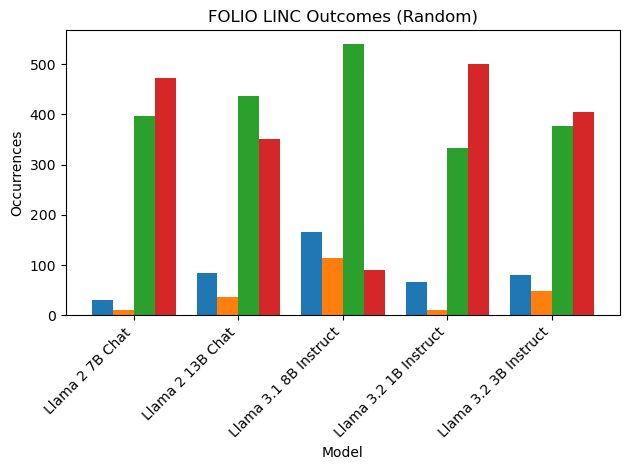

In [18]:
import matplotlib.pyplot as plt

pivot_df = linc_parses_df[linc_parses_df["Dataset"] == "FOLIO"]

pivot_df = pivot_df.set_index("Model").reindex(
    [
        "Llama 2 7B Chat",
        "Llama 2 13B Chat",
        "Llama 3.1 8B Instruct",
        "Llama 3.2 1B Instruct",
        "Llama 3.2 3B Instruct",
    ]
)

ax = pivot_df.plot(
    kind="bar",
    y=["True", "False", "Uncertain", "Error"],
    linewidth=1,
    capsize=4,
    width=0.8,
    title="FOLIO LINC Outcomes (Random)",
    legend=False
)

ax.set_ylabel("Occurrences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

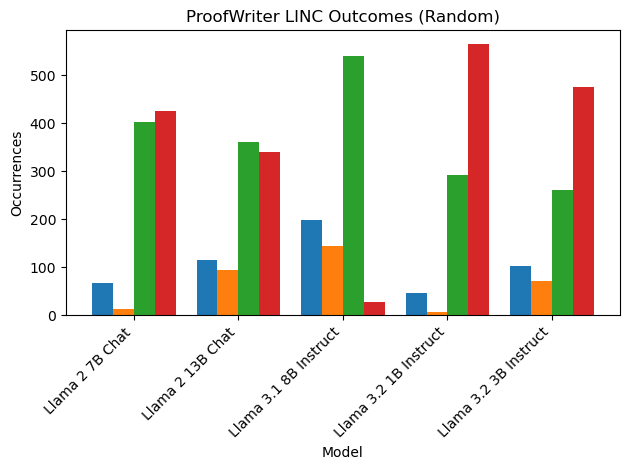

In [19]:
import matplotlib.pyplot as plt

pivot_df = linc_parses_df[linc_parses_df["Dataset"] == "ProofWriter"]

pivot_df = pivot_df.set_index("Model").reindex(
    [
        "Llama 2 7B Chat",
        "Llama 2 13B Chat",
        "Llama 3.1 8B Instruct",
        "Llama 3.2 1B Instruct",
        "Llama 3.2 3B Instruct",
    ]
)

ax = pivot_df.plot(
    kind="bar",
    y=["True", "False", "Uncertain", "Error"],
    linewidth=1,
    capsize=4,
    width=0.8,
    title="ProofWriter LINC Outcomes (Random)",
    legend=False
)

ax.set_ylabel("Occurrences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()